In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- Load dataset ---
df = pd.read_csv("../data/classification_data_raw.csv")

features = ['income', 'per_college_educated_x', 'median_contract_rent']
X = df[features]
y = df['gentrified']

# --- Scale features globally ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- Base models ---
lr = LogisticRegression(
    penalty='l2', C=0.01, class_weight='balanced', max_iter=1000, random_state=42
)
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)

# --- Final estimator (stacking meta-learner) ---
final_estimator = LogisticRegressionCV(
    cv=5, max_iter=10000, random_state=42
)

# --- Stacking model ---
stack_model = StackingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    final_estimator=final_estimator,
    passthrough=True
)

# --- Train and evaluate ---
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

print("Stacked Model Performance:")
print(classification_report(y_test, y_pred))


Stacked Model Performance:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     38880
        True       0.54      0.01      0.03      1002

    accuracy                           0.97     39882
   macro avg       0.76      0.51      0.51     39882
weighted avg       0.96      0.97      0.96     39882



In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

auc = roc_auc_score(y_test, y_prob)

print("ROC AUC:", auc)
print("PR AUC:", average_precision_score(y_test, y_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


ROC AUC: 0.7763956397903782
PR AUC: 0.11429596963381294


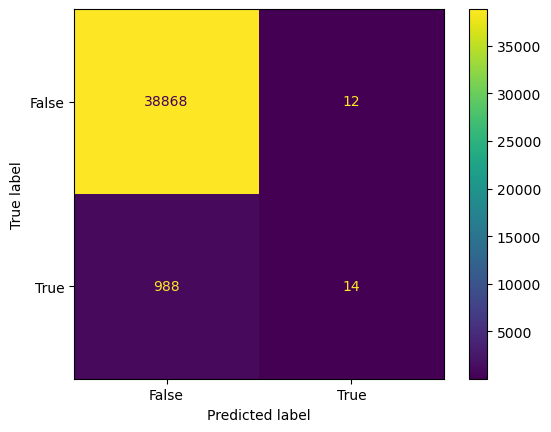

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(stack_model, X_test, y_test)


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using F1 score
f1_scores = cross_val_score(stack_model, X, y, cv=kfold, scoring='f1')

print("Cross-validated F1 scores:", f1_scores)
print("Average F1 score:", np.mean(f1_scores))


Cross-validated F1 scores: [0.02287893 0.01342282 0.02285714 0.02480916 0.02091255]
Average F1 score: 0.020976120359888335


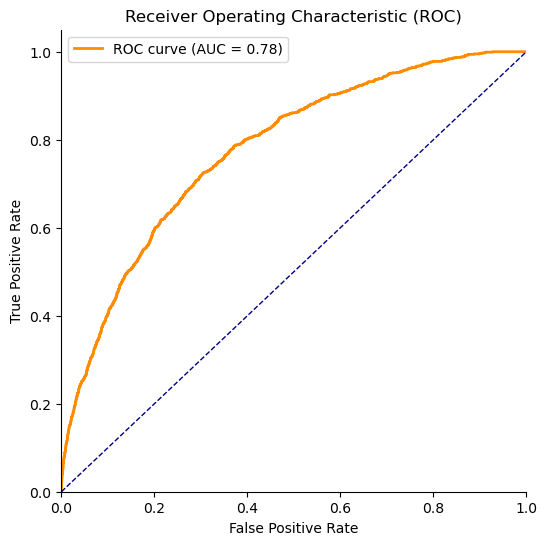

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc="upper left")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()